
# 2D Steady‐State Heat Conduction in a Square Copper Plate (FEM, 4‑node quads)

## 2D steady-state heat conduction in a square copper plate

This notebook solves the boundary value problem
$$
-\nabla\!\cdot\!\big(k\,\nabla T\big)=0 \quad \text{in } \Omega=(0,1)\times(0,1),
$$
for a homogeneous, isotropic copper plate using 4-node bilinear isoparametric quadrilateral finite elements \(Q_4\).
We take \(k=400~\mathrm{W/(m\cdot K)}\) as a representative thermal conductivity for copper.

**Boundary conditions (mixed):**
- Left edge \(x=0\): \(T=0^\circ\mathrm{C}\) (Dirichlet)  
- Right edge \(x=1\): \(T=400^\circ\mathrm{C}\) (Dirichlet)  
- Bottom \(y=0\) and Top \(y=1\): insulated (Neumann) with zero normal heat flux

$$
  q\cdot n \;=\; -\,k\,\nabla T\cdot n \;=\; 0 .
$$

**Data files expected (CSV with headers):**
- `nodal_coordinates.csv` with columns `Node, X, Y, Z`  
- `element_connectivity.csv` with columns `Element, Node1, Node2, Node3, Node4`

In [63]:
import numpy as np
import scipy.sparse.linalg as spla
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
from pathlib import Path

plt.rcParams["figure.figsize"] = (7, 5)

In [64]:
def shape_functions_Q4(xi, eta):
    N = 0.25 * np.array([ (1 - xi)*(1 - eta),
                          (1 + xi)*(1 - eta),
                          (1 + xi)*(1 + eta),
                          (1 - xi)*(1 + eta) ], dtype=float)
    dN_dxi  = 0.25 * np.array([ -(1 - eta),  (1 - eta),  (1 + eta), -(1 + eta) ], dtype=float)
    dN_deta = 0.25 * np.array([ -(1 - xi),  -(1 + xi),   (1 + xi),   (1 - xi) ], dtype=float)
    return N, dN_dxi, dN_deta

def element_stiffness_Q4(coords_e, kappa):
    Ke = np.zeros((4,4), dtype=float)
    g = 1.0/np.sqrt(3.0)
    gps = [(-g,-g), ( g,-g), ( g, g), (-g, g)]
    for (xi,eta) in gps:
        N, dN_dxi, dN_deta = shape_functions_Q4(xi, eta)
        J = np.zeros((2,2))
        J[0,0] = np.dot(dN_dxi,  coords_e[:,0])
        J[0,1] = np.dot(dN_deta, coords_e[:,0])
        J[1,0] = np.dot(dN_dxi,  coords_e[:,1])
        J[1,1] = np.dot(dN_deta, coords_e[:,1])
        detJ = np.linalg.det(J)
        if detJ <= 0:
            raise ValueError("Non-positive Jacobian determinant encountered.")
        invJ = np.linalg.inv(J)
        grad_parent = np.vstack((dN_dxi, dN_deta))
        grad_xy = invJ @ grad_parent
        dN_dx = grad_xy[0,:]
        dN_dy = grad_xy[1,:]
        B = np.vstack((dN_dx, dN_dy))
        Ke += 400.0 * (B.T @ B) * detJ  # kappa can be factored later; here set as 400 default
    # Scale to requested kappa (if different)
    return Ke * (kappa/400.0)

def element_load_Q4(coords_e, Q=0.0):
    fe = np.zeros(4, dtype=float)
    if Q == 0.0:
        return fe
    g = 1.0/np.sqrt(3.0)
    gps = [(-g,-g), ( g,-g), ( g, g), (-g, g)]
    for (xi,eta) in gps:
        N, dN_dxi, dN_deta = shape_functions_Q4(xi, eta)
        J = np.zeros((2,2))
        J[0,0] = np.dot(dN_dxi,  coords_e[:,0])
        J[0,1] = np.dot(dN_deta, coords_e[:,0])
        J[1,0] = np.dot(dN_dxi,  coords_e[:,1])
        J[1,1] = np.dot(dN_deta, coords_e[:,1])
        detJ = np.linalg.det(J)
        fe += N * Q * detJ
    return fe

def assemble_global_KF(nodes_xy, elems, kappa, Q=0.0):
    Ntot = nodes_xy.shape[0]
    K = np.zeros((Ntot,Ntot), dtype=float)
    F = np.zeros(Ntot, dtype=float)
    for e in elems:
        coords_e = nodes_xy[np.asarray(e), :]
        Ke = element_stiffness_Q4(coords_e, kappa)
        fe = element_load_Q4(coords_e, Q=Q)
        for aL, aG in enumerate(e):
            F[aG] += fe[aL]
            for bL, bG in enumerate(e):
                K[aG, bG] += Ke[aL, bL]
    return K, F


import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla

def apply_dirichlet_bc(K, F, fixed_idx, fixed_vals):
    """
    Impose Dirichlet BCs T = fixed_vals on node indices fixed_idx.
    Works for both dense (ndarray) and sparse (SciPy) K.

    Steps:
      1) F <- F - K[:, fixed] * fixed_vals
      2) Zero rows/cols of K for fixed nodes; set diag to 1
      3) F[fixed] = fixed_vals
    """
    fixed_idx  = np.asarray(fixed_idx, dtype=int).ravel()
    fixed_vals = np.asarray(fixed_vals, dtype=float).ravel()

    # Safety checks
    if fixed_idx.size != fixed_vals.size:
        raise ValueError("fixed_idx and fixed_vals must have same length")
    n = K.shape[0]
    if F.shape[0] != n:
        raise ValueError("K and F size mismatch")
    if np.any((fixed_idx < 0) | (fixed_idx >= n)):
        raise IndexError("fixed_idx contains out-of-range indices")

    # Ensure 1D RHS
    F = np.asarray(F, dtype=float).reshape(-1)

    if sp.issparse(K):
        # -------- sparse path --------
        K = K.tocsr()

        # (1) move knowns to RHS
        F = F - K[:, fixed_idx].dot(fixed_vals)

        # (2) zero rows & columns, set diag to 1
        # zero rows efficiently in LIL
        K = K.tolil()
        for i in fixed_idx:
            K.rows[i] = []
            K.data[i] = []
            K[i, i] = 1.0
        # zero columns (LIL supports column assignment)
        for j in fixed_idx:
            K[:, j] = 0.0
        # reassert diagonal = 1 after col zeroing
        for i in fixed_idx:
            K[i, i] = 1.0
        K = K.tocsr()

        # (3) set RHS at fixed nodes
        F[fixed_idx] = fixed_vals
        return K, F
    else:
        # -------- dense path --------
        K = np.array(K, dtype=float, copy=True)

        # (1) move knowns to RHS
        F = F - K[:, fixed_idx] @ fixed_vals

        # (2) zero rows & columns, set diag to 1
        K[fixed_idx, :] = 0.0
        K[:, fixed_idx] = 0.0
        K[fixed_idx, fixed_idx] = 1.0

        # (3) set RHS at fixed nodes
        F[fixed_idx] = fixed_vals
        return K, F

def solve_linear(K, F):
    """Solve K x = F for dense or sparse K."""
    return spla.spsolve(K, F) if sp.issparse(K) else np.linalg.solve(K, F)

def element_centroid_flux(coords_e, Te, kappa):
    xi = 0.0; eta = 0.0
    N, dN_dxi, dN_deta = shape_functions_Q4(xi, eta)
    xc = float(np.dot(N, coords_e[:,0]))
    yc = float(np.dot(N, coords_e[:,1]))
    J = np.zeros((2,2))
    J[0,0] = np.dot(dN_dxi,  coords_e[:,0])
    J[0,1] = np.dot(dN_deta, coords_e[:,0])
    J[1,0] = np.dot(dN_dxi,  coords_e[:,1])
    J[1,1] = np.dot(dN_deta, coords_e[:,1])
    invJ = np.linalg.inv(J)
    grad_parent = np.vstack((dN_dxi, dN_deta))
    grad_xy = invJ @ grad_parent
    dN_dx = grad_xy[0,:]; dN_dy = grad_xy[1,:]
    dTdx = float(np.dot(dN_dx, Te))
    dTdy = float(np.dot(dN_dy, Te))
    qx = -kappa * dTdx
    qy = -kappa * dTdy
    return xc, yc, qx, qy



# ---- Sparsity / band visualization for K ----
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp

def plot_K_banded(K, grid_max_nelts=2_000_000):
    """
    Visualize the sparsity (bandedness) of the global stiffness matrix K.

    - Prints shape, nnz, density, and estimated half-bandwidth = max|i-j|.
    - Figure 1: plt.spy(K) -> fast scatter of nonzeros.
    - Figure 2: dense boolean grid (filled cells for nonzeros). Skipped if K is too large.
    """
    # Basic checks
    if not hasattr(K, "shape") or len(K.shape) != 2:
        raise ValueError("K must be a 2D array or sparse matrix.")
    n, m = K.shape
    if n != m:
        print(f"Warning: K is not square ({n}x{m}). Proceeding anyway.")

    # Extract nonzero indices
    if sp.issparse(K):
        K_coo = K.tocoo()
        rows, cols = K_coo.row, K_coo.col
        nnz = K_coo.nnz
    else:
        K = np.asarray(K)
        rows, cols = np.nonzero(K)
        nnz = rows.size

    density = nnz / (n * m) if n*m > 0 else 0.0
    half_bw = int(np.max(np.abs(rows - cols))) if nnz > 0 else 0
    full_bw = 2 * half_bw + 1

    print(f"K shape: {n} x {m}")
    print(f"Nonzeros: {nnz}  (density: {density:.4%})")
    print(f"Estimated half-bandwidth: {half_bw}  (full bandwidth ~ {full_bw})")

    # --- View 1: spy plot (fast) ---
    plt.figure(figsize=(6, 6))
    plt.spy(K, markersize=1)
    plt.gca().invert_yaxis()  # row 0 at top
    plt.title("Sparsity pattern of K (spy view)")
    plt.xlabel("column index")
    plt.ylabel("row index")
    plt.tight_layout()
    plt.show()

    # --- View 2: filled grid cells (dense boolean) ---
    total_elts = n * m
    if total_elts <= grid_max_nelts:
        if sp.issparse(K):
            mask = K.tocoo()
            mask_dense = np.zeros((n, m), dtype=bool)
            mask_dense[mask.row, mask.col] = True
        else:
            mask_dense = (K != 0)

        plt.figure(figsize=(6, 6))
        # origin='upper' so row 0 is at the top (matrix-like)
        plt.imshow(mask_dense, interpolation='nearest', origin='upper')
        # Overlay approximate band edges
        if half_bw > 0:
            x = np.arange(n)
            # Diagonals y = x - half_bw and y = x + half_bw
            plt.plot(x, x - half_bw, linewidth=1)
            plt.plot(x, x + half_bw, linewidth=1)
        plt.title("Non-zero grid of K (filled cells)")
        plt.xlabel("column index")
        plt.ylabel("row index")
        plt.tight_layout()
        plt.show()
    else:
        print(f"Skipping filled-grid view (matrix too large: {n}x{m} > {grid_max_nelts} elements).")

# ---- Call the visualizer on your assembled K ----



In [65]:
# Read nodal coordinates and element connectivity list
#
nodes_df = pd.read_csv("nodal_coordinates.csv")
elems_df = pd.read_csv("element_connectivity.csv")
#
nodes_xy = nodes_df[["X","Y"]].to_numpy()
elems = elems_df[["Node1","Node2","Node3","Node4"]].to_numpy(dtype=int) - 1
#
print(f"Loaded {nodes_xy.shape[0]} nodes and {elems.shape[0]} elements.")

Loaded 441 nodes and 400 elements.


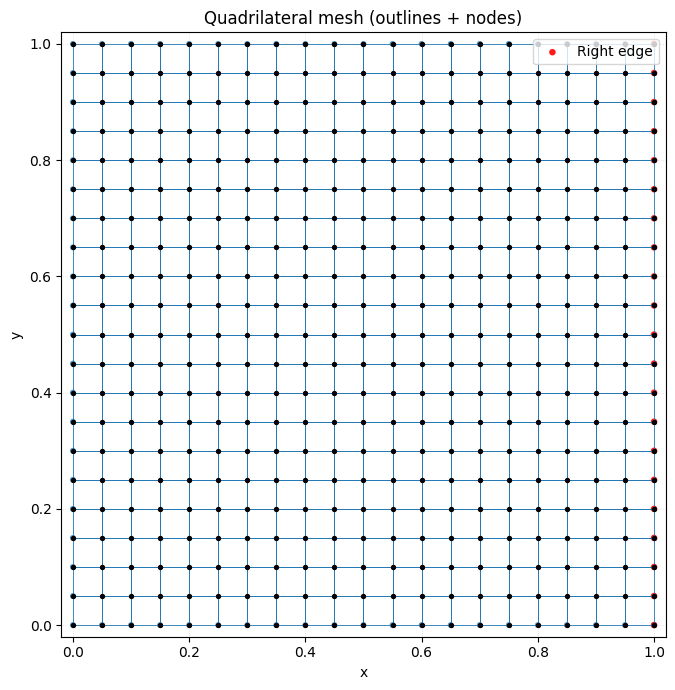

In [66]:
# Create mesh plot
# --- Mesh plot from CSVs (quad4) ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# ===== Load mesh from CSVs =====
nodes_df = pd.read_csv("nodal_coordinates.csv")          # columns: Node, X, Y, Z
ele_df   = pd.read_csv("element_connectivity.csv")       # columns: Element, Node1, Node2, Node3, Node4

# Map node IDs (possibly 1-based) to 0-based indices
node_ids = nodes_df["Node"].to_numpy()
coords   = nodes_df[["X", "Y"]].to_numpy(dtype=float)
id_to_ix = {int(nid): i for i, nid in enumerate(node_ids)}

conn_cols = ["Node1", "Node2", "Node3", "Node4"]
conn_ix = np.array([[id_to_ix[int(n)] for n in row]
                    for row in ele_df[conn_cols].to_numpy()],
                   dtype=int)  # shape: (ne, 4)

# ===== Build element polylines (closed) =====
polylines = []
for e in range(conn_ix.shape[0]):
    vidx = conn_ix[e]
    xy   = coords[vidx]                 # (4,2) in node order
    xy   = np.vstack([xy, xy[0]])       # close the loop
    polylines.append(xy)

# ===== Plot controls =====
label_nodes     = False   # set True to label node IDs
label_elements  = False   # set True to label element IDs
highlight_bdry  = True    # color boundary nodes (right = red, others = gray)

# ===== Make the figure =====
fig, ax = plt.subplots(figsize=(7, 7))

# Element outlines
lc = LineCollection(polylines, linewidths=0.6)
ax.add_collection(lc)

# All nodes (base layer)
ax.scatter(coords[:, 0], coords[:, 1], s=8, color="k", zorder=3)

# Optional: highlight boundary nodes (useful to see where Dirichlet/Neumann would go)
if highlight_bdry:
    x, y = coords[:, 0], coords[:, 1]
    tol  = 1e-12
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()

    left   = np.isclose(x, xmin, atol=tol)
    right  = np.isclose(x, xmax, atol=tol)
    bottom = np.isclose(y, ymin, atol=tol)
    top    = np.isclose(y, ymax, atol=tol)

    # Insulated edges (example): left/bottom/top in gray; right (Dirichlet) in red
    ax.scatter(x[left | bottom | top],  y[left | bottom | top],  s=18, marker='o', edgecolor='none', alpha=0.8)
    ax.scatter(x[right],                y[right],                s=22, marker='o', color='r', edgecolor='none', alpha=0.9, label="Right edge")

# Optional: labels
if label_nodes:
    for i, (xx, yy) in enumerate(coords):
        ax.text(xx, yy, str(node_ids[i]), fontsize=6, ha="left", va="bottom")

if label_elements:
    centroids = coords[conn_ix].mean(axis=1)  # (ne,2)
    for e, (cx, cy) in enumerate(centroids):
        ax.text(cx, cy, str(int(ele_df["Element"].iloc[e])), fontsize=7, ha="center", va="center", color="tab:blue")

# Tidy axes
ax.set_aspect("equal", adjustable="box")
pad_x = 0.02 * (coords[:, 0].ptp() if coords[:, 0].ptp() > 0 else 1.0)
pad_y = 0.02 * (coords[:, 1].ptp() if coords[:, 1].ptp() > 0 else 1.0)
ax.set_xlim(coords[:, 0].min() - pad_x, coords[:, 0].max() + pad_x)
ax.set_ylim(coords[:, 1].min() - pad_y, coords[:, 1].max() + pad_y)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Quadrilateral mesh (outlines + nodes)")
ax.grid(True, linestyle=":", linewidth=0.5, alpha=0.5)

if highlight_bdry:
    ax.legend(loc="upper right", frameon=True)

plt.tight_layout()
plt.show()



In [67]:
kappa = 400.0
Q = 0.0
#
K, F = assemble_global_KF(nodes_xy, elems, kappa, Q=Q)

K shape: 441 x 441
Nonzeros: 3721  (density: 1.9133%)
Estimated half-bandwidth: 22  (full bandwidth ~ 45)


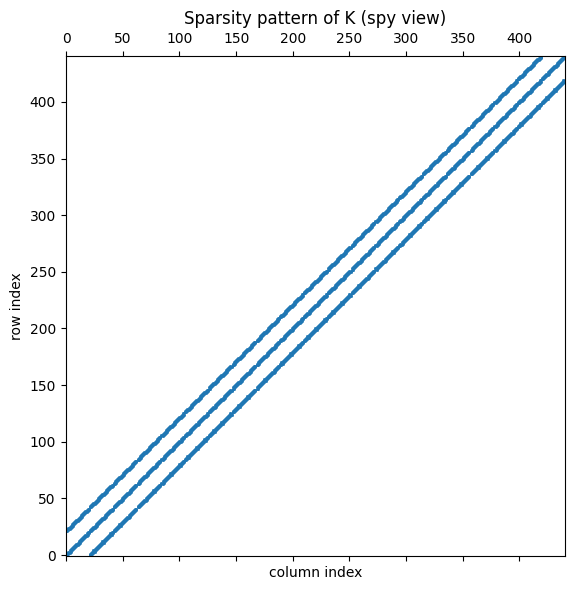

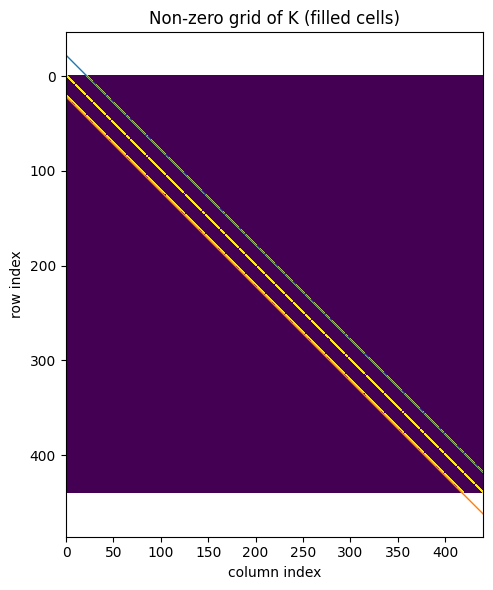

In [68]:
# Show a plot of the banded nature of the global stiffness matrix.
plot_K_banded(K)

In [69]:
#
tol = 1e-12
x = nodes_xy[:, 0]
xmin, xmax = x.min(), x.max()
tol = 1e-12
left_idx  = np.where(np.isclose(x, xmin, atol=tol))[0]
right_idx = np.where(np.isclose(x, xmax, atol=tol))[0]

bc_nodes = np.concatenate([left_idx, right_idx])
bc_vals  = np.concatenate([
    np.zeros_like(left_idx,  dtype=float),
    np.full_like(right_idx, 400.0, dtype=float)
])
K_bc, F_bc = apply_dirichlet_bc(K, F, bc_nodes, bc_vals)
T = solve_linear(K_bc, F_bc)
print("Solved. Temperature stats: min={:.3f} °C, max={:.3f} °C".format(T.min(), T.max()))


Solved. Temperature stats: min=0.000 °C, max=400.000 °C


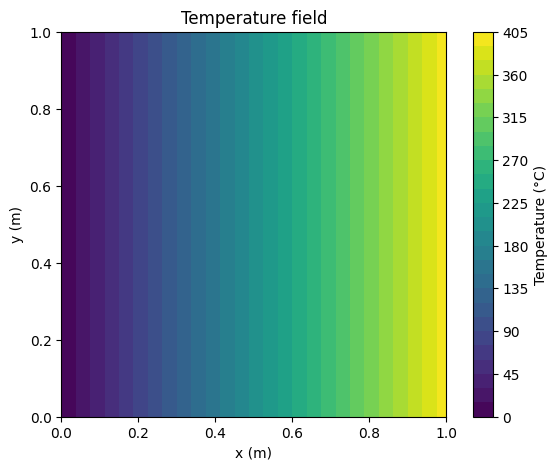

In [70]:
# Structured contour if possible; fallback to triangulation.
xu = np.unique(np.round(nodes_xy[:,0], 12))
yu = np.unique(np.round(nodes_xy[:,1], 12))
nx, ny = len(xu), len(yu)

order = np.lexsort((nodes_xy[:,0], nodes_xy[:,1]))
T_sorted = T[order]
X_sorted = nodes_xy[order,0]
Y_sorted = nodes_xy[order,1]

fig, ax = plt.subplots()
try:
    T_grid = T_sorted.reshape(ny, nx)
    X_grid = X_sorted.reshape(ny, nx)
    Y_grid = Y_sorted.reshape(ny, nx)
    cs = ax.contourf(X_grid, Y_grid, T_grid, levels=30)
    cbar = fig.colorbar(cs, ax=ax, label="Temperature (°C)")
    ax.set_title("Temperature field")
except ValueError:
    tri = Triangulation(nodes_xy[:,0], nodes_xy[:,1])
    cs = ax.tricontourf(tri, T, levels=30)
    cbar = fig.colorbar(cs, ax=ax, label="Temperature (°C)")
    ax.set_title("Temperature field (unstructured)")

ax.set_aspect('equal'); ax.set_xlabel("x (m)"); ax.set_ylabel("y (m)")
plt.show()


In [71]:

print("BC check — Left avg T: {:.3f} °C, Right avg T: {:.3f} °C".format(
    T[np.isclose(nodes_xy[:,0], nodes_xy[:,0].min())].mean(),
    T[np.isclose(nodes_xy[:,0], nodes_xy[:,0].max())].mean()
))


BC check — Left avg T: 0.000 °C, Right avg T: 400.000 °C
